```{image} ../images/radar-obs.png
:width: 400px
:align: center
```

# Radares Meteorológicos

---

## 🧭 Introducción

Este cuaderno introduce conceptos básicos de radar meteorológico, su funcionamiento y su aplicación en el monitoreo de la atmósfera. También aprenderás a acceder, procesar y visualizar datos de radar provenientes del IDEAM publicados en AWS.

## 📚 ¿Qué vas a aprender?

- Cómo funcionan los radares meteorológicos.
- Qué información se obtiene y cómo accederla desde la nube (AWS S3).
- Uso de herramientas como `xradar`, `hvplot` y `cartopy` para analizar y visualizar la información.
- Cómo estimar campos de precipitación a partir de reflectividad.

## ✅ Requisitos Previos
```{list-table}
:header-rows: 1

* - Conceptos
  - Importancia
  - Notas
* - [Introducción a Xarray](https://foundations.projectpythia.org/core/xarray.html)
  - Necesario
  - Lectura de datos multidimensionales
* - [Introducción a Py-Art](https://projectpythia.org/radar-cookbook/README.html)
  - Necesario
  - Lectura de datos de radar
* - [Introducción a Xradar](https://docs.openradarscience.org/projects/xradar/en/stable/notebooks/Read-plot-Sigmet-data-from-AWS.html)
  - Necesario
  - Lectura de datos de radar
* - [Introducción a Wradlib](https://docs.wradlib.org/en/latest/)
  - Necesario
  - Lectura de datos de radar
* - [Fundamentos de radar meteorológico](https://www.meted.ucar.edu/radar/basic_wxradar_es/)
  - Útil
  - Fundamentos básicos en radares meteorológicos
* - [Introducción a NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html)
  - Útil
  - Entender la metadata de los datos

⏱️ Tiempo estimado: 30 minutos  
✍️ Formato: Interactivo. Ejecuta y modifica el código en cada celda.

## 1. 🌐 ¿Qué es un radar meteorológico?

Los radares meteorológicos son instrumentos de teledetección activa que emiten pulsos de energía electromagnética hacia la atmósfera. A medida que estos pulsos encuentran obstáculos como gotas de lluvia, nieve o granizo, parte de la energía se dispersa de vuelta al radar. Esta **energía retrodispersada** es captada por el mismo sistema emisor y permite estimar propiedades físicas de los hidrometeoros, como su intensidad, tamaño, ubicación y movimiento.

Este principio de funcionamiento se ilustra claramente en la siguiente animación, extraída del curso _Fundamentos en radares meteorológicos_ del programa [The COMET Program – meted.ucar.edu](https://www.meted.ucar.edu):

:::{figure} ../images/radar_atten.mp4
:width: 70%
Viaje de las ondas electromágneticas en un radar. Fuente: [UCAR](https://www.meted.ucar.edu/index.php)
:::


Los radares suelen operar en modo **PPI** (_Plan Position Indicator_), donde la antena se fija en un ángulo de elevación constante y gira 360° en torno al eje vertical. Este procedimiento se repite a diferentes elevaciones para formar un **Patrón de Cobertura Volumétrica (VCP)**, que permite construir representaciones tridimensionales del estado de la atmósfera.

:::{figure} ../images/radar_scan_EM_animation.mp4
:width: 80%
Operacion de un radar meteorológico. Fuente: [UCAR](https://www.meted.ucar.edu/index.php)
:::

## 2. 🌎 Red Nacional de Radares Meteorológicos de Colombia

Colombia cuenta con una red de radares meteorológicos que monitorean de forma continua la atmósfera, especialmente los fenómenos de precipitación. Estos equipos, operados por distintas entidades públicas, están distribuidos estratégicamente para cubrir diferentes regiones del país.

La mayoría de estos radares operan en banda **C**, adecuada para monitorear lluvia a escala regional. También se incluye un radar en banda **X**, más sensible pero de menor alcance, utilizado principalmente en entornos urbanos.

A continuación se muestra un resumen de las instituciones que operan los radares en Colombia:

```{list-table}
:header-rows: 1

* - Entidad
  - Número de radares
  - Banda
* - IDEAM
  - 4
  - C
* - Aerocivil
  - 6
  - C
* - SIATA
  - 1
  - C
* - IDIGER
  - 1
  - X


### 2.1 🗺️ Mapa de ubicación de radares

En esta subsección representamos geográficamente la ubicación de los radares meteorológicos en Colombia. Utilizamos `matplotlib` junto con `cartopy`

En el siguiente mapa se muestra la ubicación geográfica de los radares meteorológicos operativos en Colombia, junto con un círculo que representa su alcance aproximado de cobertura. Esta visualización permite identificar la distribución espacial de la red y las regiones cubiertas por cada sensor.


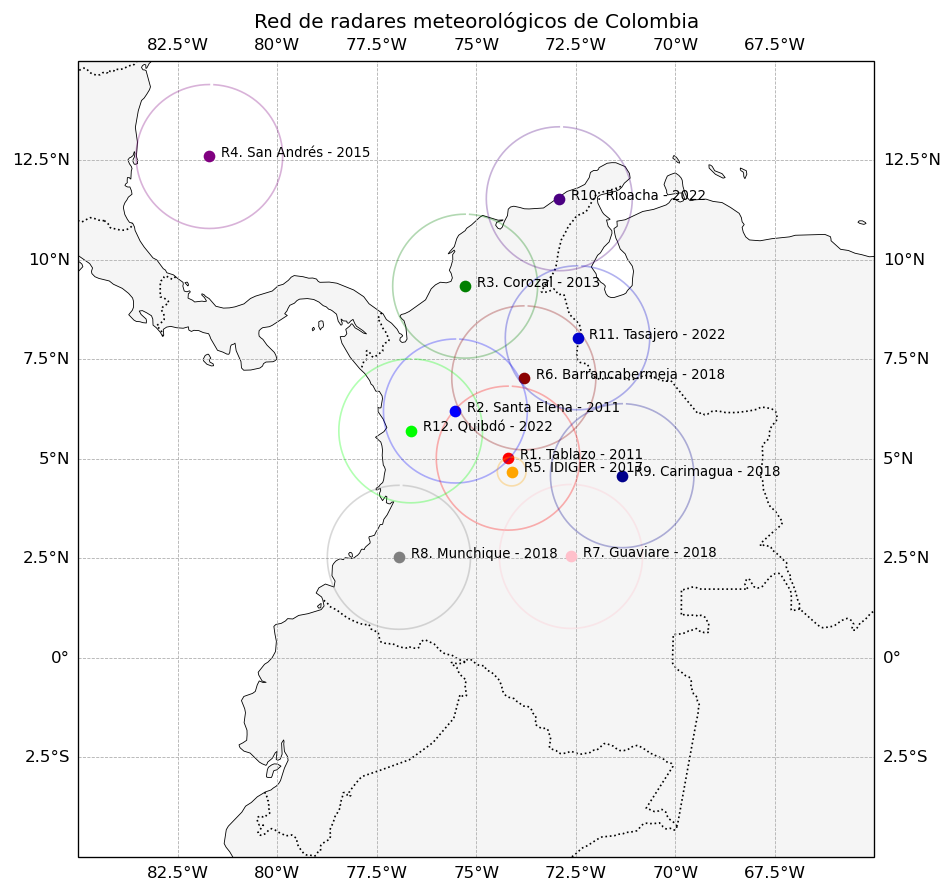

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from shapely.geometry import Point
from cartopy import geodesic

# Cargar los datos
df_radares = pd.read_csv("../data/radar_locations.csv")

# Crear figura con proyección geográfica
fig, ax = plt.subplots(
    figsize=(8, 8),
    subplot_kw={"projection": ccrs.PlateCarree()},
    dpi=120
)

# Configurar mapa base
ax.set_extent([-85, -65, -5, 15])
ax.add_feature(cfeature.LAND, facecolor="whitesmoke")
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5)

# Dibujar cada radar
for _, row in df_radares.iterrows():
    lon, lat = row["lon"], row["lat"]
    name = row["Name"]
    color = row["color"]
    
    # Punto del radar
    ax.plot(lon, lat, "o", color=color, markersize=6)
    ax.text(lon + 0.3, lat, name, fontsize=8)

    # Determinar radio en km (IDIGER tiene menor alcance)
    radio_km = 40 if "IDIGER" in name.upper() else 200
    
    # Dibujar círculo geodésico
    circle = geodesic.Geodesic().circle(lon=lon, lat=lat, radius=radio_km * 1000, n_samples=100)
    ax.plot(*circle.T, color=color, linewidth=1, alpha=0.3)

ax.set_title("Red de radares meteorológicos de Colombia")
plt.tight_layout()

### 2.2 📡 Radares meteorológicos del IDEAM disponibles en AWS

El Instituto de Hidrología, Meteorología y Estudios Ambientales (IDEAM) ha puesto a disposición pública los datos de sus radares meteorológicos mediante un repositorio en la nube de Amazon Web Services (AWS). Este repositorio facilita el acceso a información cruda de reflectividad y otros productos en formato propietario (SIGMET/IRIS), permitiendo su análisis mediante herramientas especializadas.

La estructura del bucket es la siguiente:

```text
s3://s3-radaresideam/l2_data/YYYY/MM/DD/Radar_name/RRRAAMMDDTTTTTT.RAWXXXX 

Donde:

- `YYYY`, `MM`, `DD` indican el año, mes y día del escaneo.

- `Radar_name` es el nombre del radar (por ejemplo: *Guaviare*, *Munchique*, *Barrancabermeja*, *Carimagua*).

- `RRRAAMMDDTTTTTT.RAWXXXX` es el nombre del archivo en formato SIGMET, compuesto por:

  - `RRR`: código del radar (ej. `GUA` para Guaviare)
  - `AA`: año en 2 dígitos
  - `MM`: mes
  - `DD`: día
  - `TTTTTT`: hora de adquisición (UTC)
  - `RAWXXXX`: identificador interno generado por el software IRIS


IDEAM actualmente dispone de archivos para sus radares principales desde aproximadamente 2018. Los datos están organizados por fecha, por lo que es necesario navegar dentro del bucket por año, mes y día para acceder a los archivos específicos.


```{hint}
💡 **Tip**: En los notebooks también puedes ejecutar comandos de línea de comandos (CLI) anteponiendo un signo de exclamación (`!`).

Por ejemplo, para listar los archivos disponibles en el bucket de radares del IDEAM para una fecha específica:

```bash
!aws s3 ls --no-sign-request s3://s3-radaresideam/l2_data/2021/09/19/


In [2]:
!aws s3 ls --no-sign-request s3://s3-radaresideam/l2_data/2021/09/19/

                           PRE Guaviare/
                           PRE Munchique/


## 3. 📥 Acceso a los datos de radar usando Python

IDEAM publica los datos de sus radares meteorológicos en un bucket público de Amazon Web Services (AWS). Gracias a herramientas como `fsspec` y `xradar`, es posible explorar estos datos, filtrarlos por fecha y estación, y analizarlos sin necesidad de descargarlos manualmente desde la web.



### 3.1 🔎 Exploración de archivos disponibles en el bucket

Primero, se establece una conexión con el bucket S3 de IDEAM utilizando `fsspec`. Esto permite buscar archivos según una ruta de interés que incluye fecha y nombre del radar.


In [3]:
import fsspec

# Crear sistema de archivos con acceso anónimo
fs = fsspec.filesystem("s3", anon=True)

# Buscar archivos de radar disponibles en una fecha específica
files = sorted(fs.glob("s3-radaresideam/l2_data/2022/08/09/Carimagua/CAR22080919*"))
files[:5]  # Mostrar los primeros 5 archivos encontrados

['s3-radaresideam/l2_data/2022/08/09/Carimagua/CAR220809190003.RAWDSVV',
 's3-radaresideam/l2_data/2022/08/09/Carimagua/CAR220809190315.RAWDSW0',
 's3-radaresideam/l2_data/2022/08/09/Carimagua/CAR220809190401.RAWDSW3',
 's3-radaresideam/l2_data/2022/08/09/Carimagua/CAR220809190505.RAWDSW8',
 's3-radaresideam/l2_data/2022/08/09/Carimagua/CAR220809191003.RAWDSWM']

```{hint}
🛠️ **Personalización de la búsqueda**

La ruta utilizada en el método `fs.glob()`:

s3-radaresideam/l2_data/2022/08/09/Carimagua/CAR22080919*

puede ser modificada para consultar archivos de otras fechas o radares. Solo debes ajustar los siguientes componentes:

- `2022/08/09`: la fecha del escaneo en formato `YYYY/MM/DD`
- `Carimagua`: el nombre del radar (por ejemplo: `Guaviare`, `Munchique`, `Barrancabermeja`)
- `CAR22080919*`: el patrón del nombre del archivo. Puedes usar comodines como `*` para seleccionar varios archivos.

Esto te permite explorar diferentes días o estaciones según tu interés de análisis.

### 3.2 💾 Descarga temporal y lectura de archivos con Xradar

Una vez localizado un archivo de interés, este puede ser **descargado temporalmente al sistema local** utilizando `fsspec.open_local`. Luego, puede ser leído con `xradar`, el cual retorna una estructura jerárquica del tipo `DataTree`, que organiza los barridos (sweeps) contenidos en el archivo.


In [4]:
import xradar as xd
import fsspec
import cmweather
# Preparamos un archivo para abrir de manera local desde el bucket S3
task_file = fsspec.open_local(
    f"simplecache::s3://{files[7]}",
    s3={"anon": True},
    filecache={"cache_storage": "."}  # Carpeta donde se almacena temporalmente
)

# Leemos el archivo utilizando xradar
radar = xd.io.open_iris_datatree(task_file)

# Visualizamos el contenido del datatree
display(radar)

<xarray.DataTree>
Group: /
│   Dimensions:              (sweep: 1)
│   Dimensions without coordinates: sweep
│   Data variables:
│       volume_number        int64 8B 0
│       platform_type        <U5 20B 'fixed'
│       instrument_type      <U5 20B 'radar'
│       time_coverage_start  <U20 80B '2022-08-09T19:15:05Z'
│       time_coverage_end    <U20 80B '2022-08-09T19:16:21Z'
│       longitude            float64 8B -71.33
│       altitude             float64 8B 206.0
│       latitude             float64 8B 4.564
│       sweep_fixed_angle    (sweep) float64 8B 0.5
│       sweep_group_name     (sweep) int64 8B 0
│   Attributes:
│       Conventions:      None
│       instrument_name:  carimagua-radar
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           Sigmet
│       history:          None
│       comment:          Primera tarea del modo precipitacion / 0.5
│       scan_name:        SURVP       
├── Group: /sweep_0
│       Dimensions:            (azimuth: 720, range: 994)
│       Coordinates:
│           elevation          (azimuth) float32 3kB ...
│           time               (azimuth) datetime64[ns] 6kB 2022-08-09T19:15:56.89100...
│         * range              (range) float32 4kB 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
│           longitude          float64 8B ...
│           latitude           float64 8B ...
│           altitude           float64 8B ...
│         * azimuth            (azimuth) float32 3kB 0.03571 0.5795 ... 359.0 359.6
│       Data variables: (12/17)
│           DBTH               (azimuth, range) float32 3MB ...
│           DBZH               (azimuth, range) float32 3MB ...
│           VRADH              (azimuth, range) float32 3MB ...
│           WRADH              (azimuth, range) float32 3MB ...
│           ZDR                (azimuth, range) float32 3MB ...
│           KDP                (azimuth, range) float32 3MB ...
│           ...                 ...
│           DB_DBZE8           (azimuth, range) float32 3MB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
├── Group: /radar_parameters
│       Dimensions:    ()
│       Coordinates:
│           longitude  float64 8B ...
│           latitude   float64 8B ...
│           altitude   float64 8B ...
├── Group: /georeferencing_correction
│       Dimensions:    ()
│       Coordinates:
│           longitude  float64 8B ...
│           latitude   float64 8B ...
│           altitude   float64 8B ...
└── Group: /radar_calibration

📘 `xradar` utiliza `xarray` y devuelve una estructura tipo `DataTree`, que organiza jerárquicamente la información contenida en los archivos SIGMET/IRIS, incluyendo múltiples niveles de escaneo por elevación.

### 3.3 📊 Gráfico de reflectividad

Una vez cargado el archivo con `xradar`, podemos acceder a un barrido individual (por ejemplo, `sweep_0`) y visualizar la reflectividad horizontal (`DBZH`) utilizando la funcionalidad [`xarray.plot`](https://docs.xarray.dev/en/latest/user-guide/plotting.html) que se encuentra incorporada en `xarray`.

Este primer gráfico mostrará la reflectividad en coordenadas de azimut y rango, tal como fue registrada por el radar.


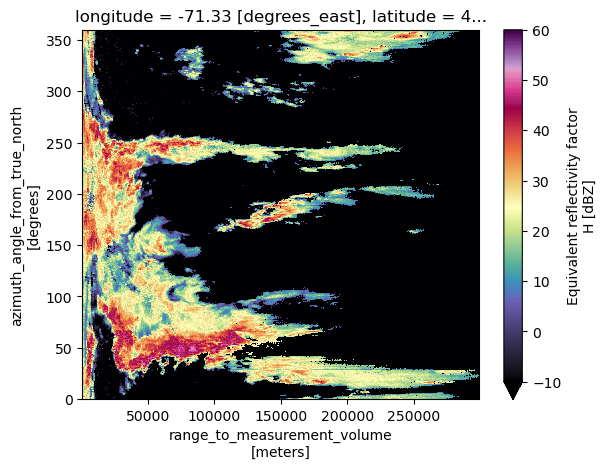

In [5]:
# Accedemos al primer barrido (elevación más baja)
sweep = radar["sweep_0"]

# Visualizamos la reflectividad horizontal (DBZH)
sweep["DBZH"].plot(cmap="ChaseSpectral", vmin=-10, vmax=60);

🎯 Este tipo de visualización es útil para inspeccionar rápidamente los valores de reflectividad en coordenadas polares. La reflectividad se mide en decibelios Z (`dBZ`) y representa la intensidad de los retornos del radar.

### 3.4 🌐 Georreferenciación de datos de radar

Los datos de radar inicialmente se encuentran en coordenadas polares: **azimuth** (ángulo de rotación horizontal) y **range** (distancia radial). Para representar estos datos en un sistema de coordenadas cartesianas (x, y, z), es necesario aplicar un proceso de **georreferenciación**.

La librería `xradar` permite realizar este proceso fácilmente con el método `.xradar.georeference()`.


In [6]:
# Aplicamos georreferenciación al datatree completo
radar = radar.xradar.georeference()

# Inspeccionamos el barrido ya georreferenciado
display(radar["sweep_0"])

<xarray.DataTree 'sweep_0'>
Group: /sweep_0
    Dimensions:            (sweep: 1, azimuth: 720, range: 994)
    Coordinates:
        elevation          (azimuth) float64 6kB 0.4779 0.4779 ... 0.4779 0.4779
        time               (azimuth) datetime64[ns] 6kB 2022-08-09T19:15:56.89100...
      * range              (range) float32 4kB 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
        longitude          float64 8B -71.33
        latitude           float64 8B 4.564
        altitude           float64 8B 206.0
      * azimuth            (azimuth) float32 3kB 0.03571 0.5795 ... 359.0 359.6
        crs_wkt            int64 8B 0
        x                  (azimuth, range) float64 6MB 0.6231 0.8101 ... -2.191e+03
        y                  (azimuth, range) float64 6MB 999.9 1.3e+03 ... 2.987e+05
        z                  (azimuth, range) float64 6MB 214.4 216.9 ... 7.948e+03
    Dimensions without coordinates: sweep
    Data variables: (12/17)
        DBTH               (azimuth, range) float32 3MB ...
        DBZH               (azimuth, range) float32 3MB ...
        VRADH              (azimuth, range) float32 3MB ...
        WRADH              (azimuth, range) float32 3MB ...
        ZDR                (azimuth, range) float32 3MB ...
        KDP                (azimuth, range) float32 3MB ...
        ...                 ...
        DB_DBZE8           (azimuth, range) float32 3MB ...
        sweep_mode         <U20 80B ...
        sweep_number       int64 8B ...
        prt_mode           <U7 28B ...
        follow_mode        <U7 28B ...
        sweep_fixed_angle  float64 8B ...

🌐 La georreferenciación agrega nuevas coordenadas físicas `x`, `y` y `z` que representan la ubicación espacial real del haz de radar sobre la superficie terrestre. Esto es esencial para graficar en mapas o combinar con otras fuentes geoespaciales.

### 3.5 🗺️ Visualización georreferenciada

Una vez que los datos han sido georreferenciados, podemos generar una visualización en coordenadas cartesianas usando las nuevas variables `x` e `y`. Esto permite observar la reflectividad del radar en el espacio físico real, facilitando su integración con mapas o capas geográficas.

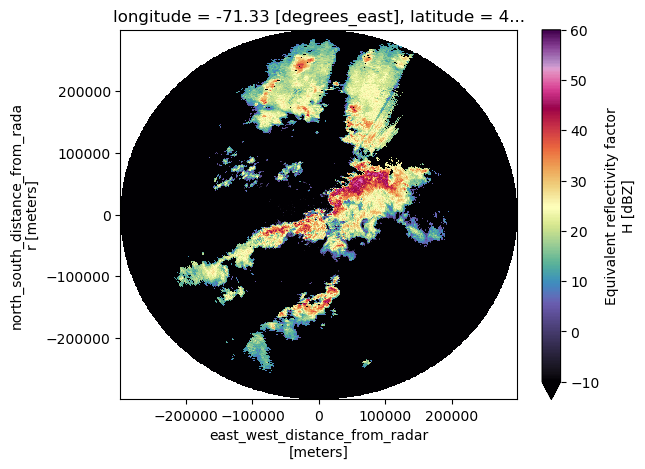

In [7]:

# Graficamos la reflectividad horizontal usando coordenadas georreferenciadas
radar["sweep_0"]["DBZH"].plot(
    x="x",
    y="y",
    cmap="ChaseSpectral",
    vmin=-10,
    vmax=60
);

🗺️ Esta visualización representa los datos del radar en un plano cartesiano, donde la ubicación espacial ya no depende de azimut y rango, sino de distancias en metros respecto al radar (coordenadas x, y).


### 3.6 🗺️ Visualización en sistema de coordenadas geográficas

Para representar los datos de reflectividad en un mapa geográfico, es necesario convertir el sistema de coordenadas cartesianas del radar a un sistema proyectado. Podemos obtener esta proyección directamente desde el objeto radar utilizando `xradar.georeference.get_crs()` y crear una proyección compatible con `cartopy`.


In [8]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Obtener el sistema de referencia proyectado desde el radar
proj_crs = xd.georeference.get_crs(radar["sweep_0"].ds)

# Crear una proyección de Cartopy usando ese CRS
cart_crs = ccrs.Projection(proj_crs)

🧭 Esta proyección permitirá superponer correctamente los datos del radar sobre mapas de costas, fronteras y otros elementos geográficos usando `cartopy`.

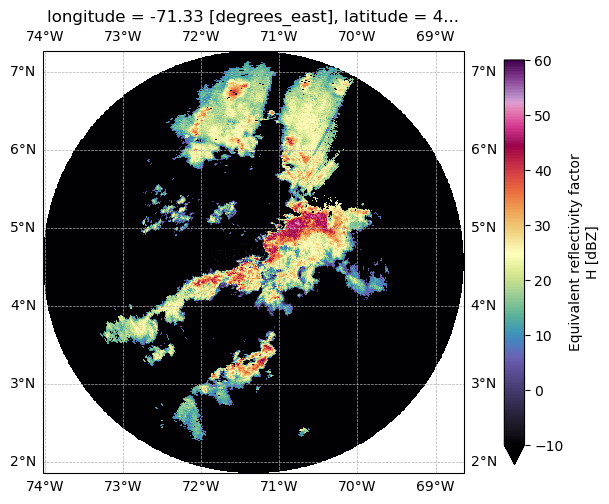

In [9]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
radar["sweep_0"]["DBZH"].plot(
    x="x",
    y="y",
    cmap="ChaseSpectral",
    transform=cart_crs,
    cbar_kwargs=dict(pad=0.075, shrink=0.75),
    vmin=-10,
    vmax=60,
)
ax.coastlines()
ax.gridlines(draw_labels=True, ls="--", lw=0.5);

🌐 Este gráfico muestra la reflectividad del radar proyectada sobre un sistema de coordenadas geográficas. Es útil para análisis meteorológico, estudios hidrológicos y validación con otras fuentes de datos espaciales.


## 4. 🌧️ Estimación de lluvia a partir de reflectividad

Una de las aplicaciones más comunes del radar meteorológico es la estimación de tasas de precipitación. Para ello se utiliza una relación empírica entre la **reflectividad Z** y la **intensidad de lluvia R**, conocida como relación **Z–R**.

Una de las formas más conocidas y utilizadas es la propuesta por **Marshall & Gunn (1953)**:

$$
Z = 200 \cdot R^{1.6}
$$

Despejando para \( R \):

$$
R = \left( \frac{Z}{200} \right)^{1/1.6}
$$

```{warning}
⚠️ La reflectividad del radar está dada en unidades decibélicas:  
\( Z_{dBZ} = 10 \cdot \log_{10}(Z) \).  
Para aplicar la ecuación, es necesario convertirla a unidades lineales:

$$
Z = 10^{(Z_{dBZ} / 10)}
$$

A continuación, implementamos este procedimiento paso a paso para estimar la lluvia a partir de un barrido de reflectividad horizontal (`DBZH`):


In [10]:
# Reflectividad en unidades logarítmicas (dBZ)
ref_log = radar["sweep_0"]["DBZH"]

# Conversión a unidades lineales
ref_lin = 10 ** (ref_log / 10)

# Aplicación de la ecuación de Marshall & Gunn (1953)
rr = (1 / 200) ** (1 / 1.6) * ref_lin ** (1 / 1.6)

Ahora podemos visualizar el campo de lluvia generado

### 4.1 🗺️ Visualización del campo de lluvia


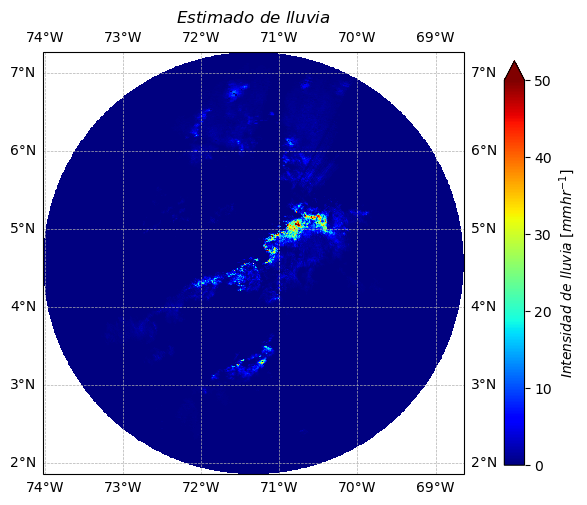

In [12]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
rr.plot(
    x="x",
    y="y",
    cmap="jet",
    transform=cart_crs,
    cbar_kwargs=dict(
        pad=0.075, shrink=0.75, label=r"$Intensidad \ de \ lluvia \ [mm hr^{-1}]$"
    ),
    vmin=0,
    vmax=50,
)
ax.set_title(r"$Estimado \ de \ lluvia$")
ax.coastlines()
ax.gridlines(draw_labels=True, ls="--", lw=0.5);

---

## ✅ Conclusiones

En este cuadernillo exploramos el acceso, procesamiento y visualización de datos de radares meteorológicos del IDEAM utilizando herramientas abiertas en Python.

📌 Aprendimos a:

- Consultar y explorar archivos disponibles en el bucket público de AWS (`s3://s3-radaresideam`).
- Leer datos de radar en formato SIGMET utilizando la librería `xradar`.
- Georreferenciar la información de reflectividad y proyectarla en coordenadas físicas reales.
- Visualizar la reflectividad horizontal tanto en coordenadas polares como geográficas.
- Estimar campos de precipitación utilizando la ecuación de **Marshall & Gunn (1953)**.

Este flujo de trabajo permite aprovechar el valor de los datos de radar meteorológico para aplicaciones hidrometeorológicas, vigilancia de tormentas y estudios atmosféricos de alta resolución.

```{note}
🔧 Estas herramientas están pensadas para análisis exploratorios. Para aplicaciones operativas o validación cuantitativa, se recomienda el uso de datos calibrados y técnicas más avanzadas de estimación de lluvia.


## 📚 Otros recursos

A continuación, se listan recursos clave y bibliografía utilizada en el desarrollo de este cuadernillo:

### 🧰 Herramientas y documentación

- [xradar — Open Radar Science](https://docs.openradarscience.org/projects/xradar/en/stable/)  
- [fsspec — Filesystem specification](https://filesystem-spec.readthedocs.io/en/latest/)
- [cartopy — Cartographic tools for Python](https://scitools.org.uk/cartopy/docs/latest/)
- [AWS CLI — Amazon Web Services Command Line Interface](https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-welcome.html)

### 📘 Lecturas recomendadas

- [Radar Cookbook — Project Pythia](https://projectpythia.org/radar-cookbook/README.html)  
- [Fundamentos de Radar Meteorológico — The COMET Program (UCAR)](https://www.meted.ucar.edu/radar/basic_wxradar_es/)


### 📄 Referencias bibliográficas

- Grover, M., Sherman, Z., Sharma, M., Ladino, A., Camron, C., & Radar Cookbook Contributors. (2023). *Radar Cookbook*. Zenodo. https://doi.org/10.5281/zenodo.8075855  
- Rose, B. E. J., Kent, J., Tyle, K., Clyne, J., Banihirwe, A., Camron, D., Ford, R., Morley, J., Grover, M., et al. (2023). *Pythia Foundations (Version v2023.05.01)*. Zenodo. https://doi.org/10.5281/zenodo.7884572  
- Marshall, J. S., & Palmer, W. M. (1948). *The distribution of raindrops with size*. J. Atmos. Sci., 5, 165–166. https://doi.org/10.1175/1520-0469(1948)005%3C0165:TDORWS%3E2.0.CO;2
